# Convergence Tests

In this notebook, we visualise the results from the `magpy` convergence tests. These tests ensure that the numerical methods are implemented correctly. 

**Running the tests**
Before executing this notebook, you'll need to run the convergence tests. In order to do this you must:
1. Clone the Magpy repository at https://github.com/owlas/magpy
2. Compile the Magpy library
3. Compile and run the convergence tests:
  - `cd /path/to/magpy/directory`
  - `make libmoma.so`
  - `make test/convergence/run`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

datapath = '../../../test/convergence/output/'

## Task 1 - 1D non-stiff SDE

We simulate the following 1-dimensional SDE, which has an analytic solution

$$dX(t) = aX(t)dt + bX(t)dW(t)$$

 - $a=-1.0$
 - $b=1.0$

In [2]:
# load results
path = datapath + 'task1/'
files = !ls {path}
results = {name: np.fromfile(path + name) for name in files if name!='dt'}
dts = np.fromfile(path + 'dt')

In [3]:
tvecs = {
    i: dts[i] * np.arange(len(results['heun'+str(i)]))
    for i in range(len(dts))
}

The following plot shows $x(t)$ for:
 - analytic
 - Heun with large time step
 - implicit with large time step
 
Both methods look accurate

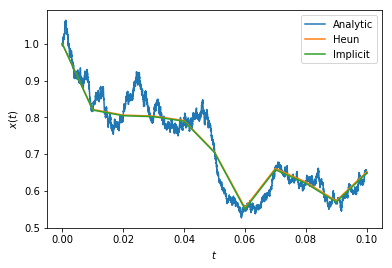

In [4]:
plt.plot(tvecs[0], results['true'], label='Analytic')
plt.plot(tvecs[3], results['heun3'], label='Heun')
plt.plot(tvecs[3], results['implicit3'], label='Implicit')
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.legend()

## Task 2 - 1D stiff SDE

We introduce stiffness into the 1D problem in order to compare the explicit (Heun) and implicit methods. This is done here by creating a large separation in timescales (the deterministic dynamics are fast, the random dynamics are slow).

$$dX(t) = aX(t)dt + bX(t)dW(t)$$

 - $a=-20.0$
 - $b=5.0$

In [5]:
# load results
path = datapath + 'task2/'
files = !ls {path}
results = {name: np.fromfile(path + name) for name in files if name!='dt'}
dts = np.fromfile(path + 'dt')

In [6]:
tvecs = {
    i: dts[i] * np.arange(len(results['heun'+str(i)]))
    for i in range(len(dts))
}

The plot of $x(t)$ shows that the explicit solver performs poorly on the stiff problem, as expected. The implicit solution looks accurate.

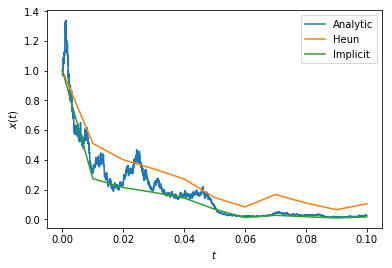

In [7]:
plt.plot(tvecs[0], results['true'], label='Analytic')
plt.plot(tvecs[3], results['heun3'], label='Heun')
plt.plot(tvecs[3], results['implicit3'], label='Implicit')
plt.xlabel('$t$'); plt.ylabel('$x(t)$'); plt.legend()

## Task 3 - 1D unstable system

We introduce instability by simulating a system that drifts to infinity.

$$dX(t) = aX(t)dt + bX(t)dW(t)$$

 - $a=1.0$
 - $b=0.1$

In [8]:
# load results
path = datapath + 'task3/'
files = !ls {path}
results = {name: np.fromfile(path + name) for name in files if name!='dt'}

The implicit solver blows up for these unstable problems. The explicit solver is able to track the trajectory closely.

(0.999, 1.001)

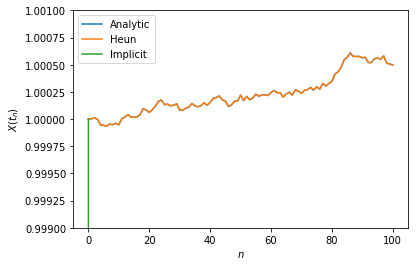

In [9]:
plt.plot(results['true'], label='Analytic')
plt.plot(results['heun'], label='Heun')
plt.plot(results['implicit'], label='Implicit')
plt.legend(), plt.ylabel('$X(t_n)$'); plt.xlabel('$n$')
plt.ylim(0.999, 1.001)

## Task 4 - Zero-temperature LLG convergence

At $T=0$ the Landau-Lifshitz-Gilbret equation for a single particle is deterministic and has a known solution. We compare the ability of the explicit and implicit methods to integrate the LLG.

In [10]:
# Load results
path = datapath + 'task4/'
files = !ls {path}
results = {name: np.fromfile(path + name).reshape((-1,3)) for name in files if name!='dt'}
dts = np.fromfile(path + 'dt')

Below is an example of the true trajectory of the x,y,z coordinates of magnetisation.

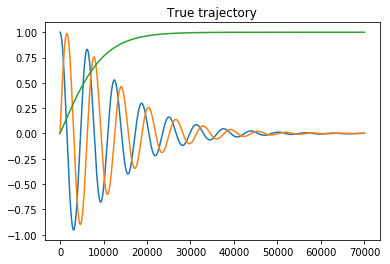

In [11]:
plt.plot(results['true'])
plt.title('True trajectory')

### Residual plots

Below we compare three integrators:
 - Explicit (Heun)
 - Implicit slow (uses a high tolerance in the internal Quasi-newton solver)
 - Implicit mid (uses a medium tolerance in the internal Quasi-newton solver)
 
We compare the residuals (difference between the true and estimated trajectories) in x,y,z for a number of time step sizes. Note that we are using reduced time (see docs elsewhere).

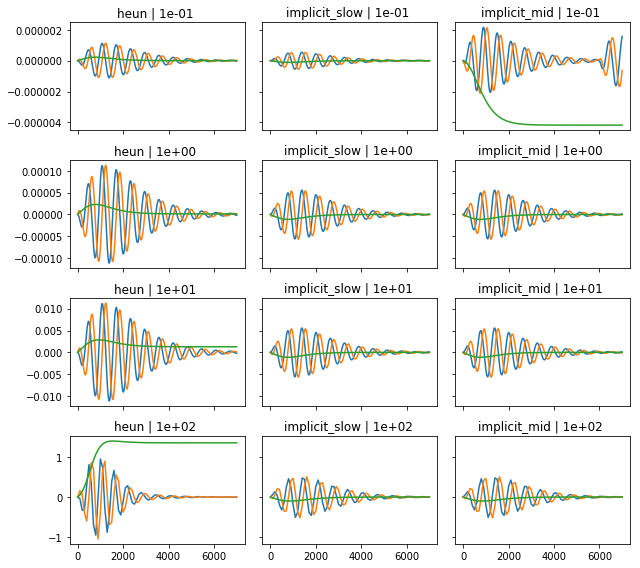

In [12]:
integ_names = ['heun', 'implicit_slow', 'implicit_mid']
dt_indices = range(len(dts))

fg, axs = plt.subplots(nrows=len(dts), ncols=len(integ_names),
                       sharey='row', sharex=True,
                       figsize=(3*len(integ_names),2*len(dts)))
for ax_row, dt_idx in zip(axs, dt_indices):
    for ax, name in zip(ax_row, integ_names):
        mag = results[name + str(dt_idx)]
        true = results['true'][::10**dt_idx]
        time = dts[dt_idx] * np.arange(mag.shape[0])
        ax.plot(time, mag-true)
        ax.set_title('{} | {:1.0e} '.format(name, dts[dt_idx]))
plt.tight_layout()

From the above results we make three observations:
 1. For the same time step, the implicit scheme (slow) is more accurate than the explicit scheme
 2. The implicit method is stable at larger time steps compared to the explicit scheme (see dt=1e-2)
 3. Guidelines for setting the implicit quasi-Newton tolerance:
     - As we reduce the time step, the required tolerance on the quasi-Newton solver must be smaller.
     - If the tolerance is not small enough the solution blows up (see top right)
     - If the tolerance is small enough, decreasing the tolerance further has little effect (compare 2nd and 3rd column).

### Compare trajectories

We can also investigate the estimated trajectories of the x,y,z components for each solver and tolerance level.

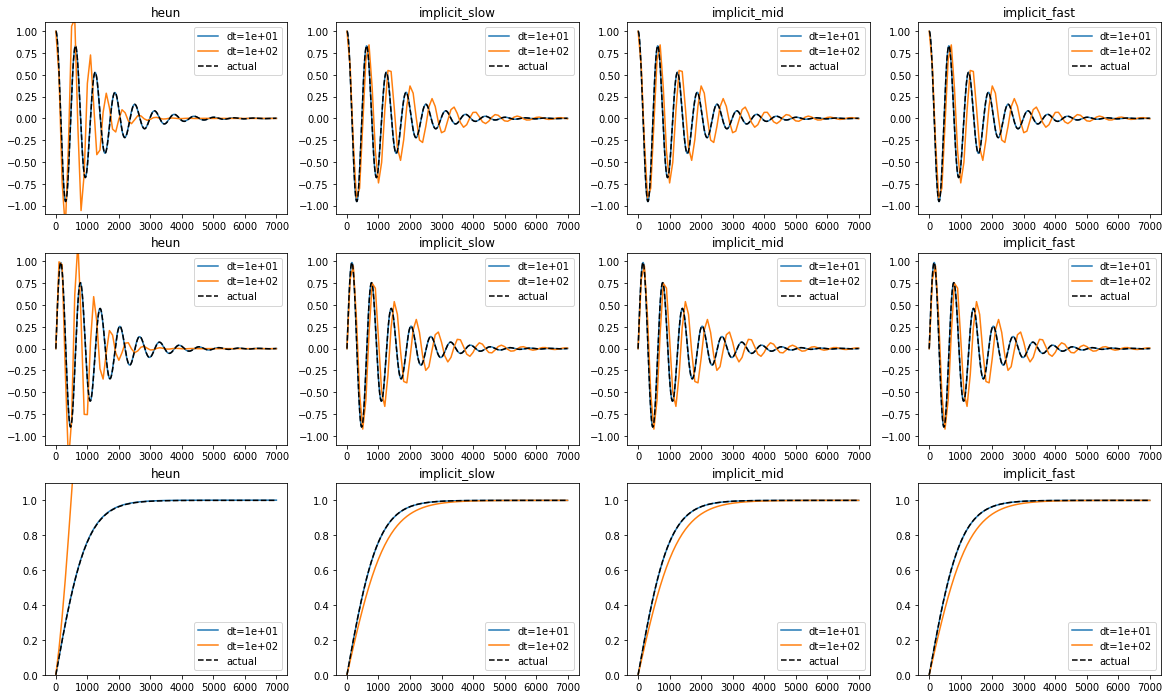

In [13]:
intes = ['heun', 'implicit_slow', 'implicit_mid', 'implicit_fast']
dt_indices = range(2,4)

fg, axs = plt.subplots(nrows=3, ncols=len(intes), figsize=(5*len(intes), 12))
for axrow, direction in zip(axs, range(3)):
    for ax, inte in zip(axrow, intes):
        for idx in dt_indices:
            numerical = results[inte+str(idx)][:,direction]
            time = dts[idx] * np.arange(numerical.size)
            ax.plot(time, numerical, label='dt={:1.0e}'.format(dts[idx]))
        actual = results['true'][:,direction]
        time = dts[0] * np.arange(actual.size)
        ax.plot(time, actual, 'k--', label='actual')
        ax.legend()
        ax.set_title(inte)
        ax.set_ylim(0 if direction==2 else -1.1 ,1.1)

## Task 5 - stochastic LLG global convergence

We now perform finite-temperature simulations of the LLG equation using the explicit and implicit scheme. We determine the global convergence (i.e. the increase in accuracy with decreasing time step). 

We expect the convergence to be linear in `log-log` space and have a convergence rate (slope) of 0.5

Files are ordered from smallest timestep at index `0` to lowest at index `4`.

Below we show an example of the problem, which we are solving.

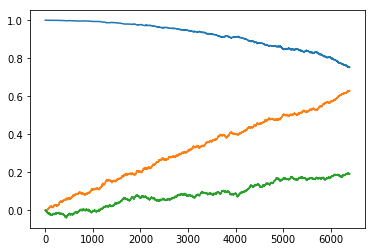

In [14]:
x = np.fromfile(datapath+'task5/example_sol').reshape((-1,3))
plt.plot(x);

### Implicit midpoint 

In [17]:
fnames = !ls {datapath}task5/implicit*
global_sols = [np.fromfile(fname).reshape((-1,3)) for fname in fnames]

In [18]:
# Compute difference between solutions at consecutive timesteps
diffs = np.diff(global_sols, axis=0)

# Take err as L2 norm
err = np.linalg.norm(diffs, axis=2)

# Compute expected error
Eerr = np.mean(err, axis=1)

In [19]:
# Load the dt values
dts = np.fromfile(datapath+'task5/dt')[1:]

In [20]:
# Fit a straight line
a,b = np.linalg.lstsq(np.stack([np.ones_like(dts), np.log2(dts)]).T, np.log2(Eerr))[0]

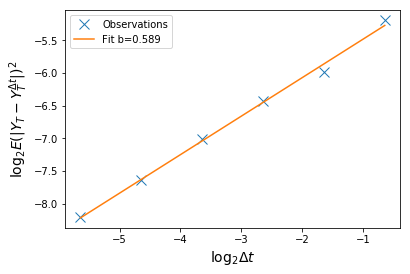

In [21]:
plt.plot(np.log2(dts), np.log2(Eerr), 'x', ms=10, label='Observations')
plt.plot(np.log2(dts), a + np.log2(dts)*b, '-', label='Fit b={:.3f}'.format(b))
plt.xlabel('$\\log_2 \\Delta t$', fontsize=14)
plt.ylabel('$\\log_2 E (\\left| Y_T-Y_T^{\\Delta t}\\right|)^2$', fontsize=14)
plt.legend()

### Heun

In [22]:
fnames = !ls {datapath}task5/heun*
global_sols = [np.fromfile(fname).reshape((-1,3)) for fname in fnames]

In [23]:
# Compute difference between solutions at consecutive timesteps
diffs = np.diff(global_sols, axis=0)

# Take err as L2 norm
err = np.linalg.norm(diffs, axis=2)

# Compute expected error
Eerr = np.mean(err, axis=1)

In [24]:
# Fit a straight line
a,b = np.linalg.lstsq(np.stack([np.ones_like(dts), np.log2(dts)]).T, np.log2(Eerr))[0]

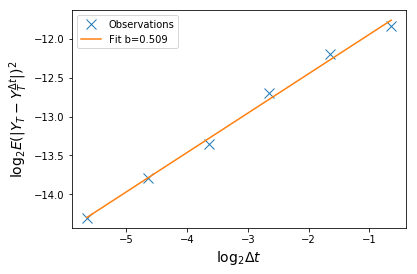

In [25]:
plt.plot(np.log2(dts), np.log2(Eerr), 'x', ms=10, label='Observations')
plt.plot(np.log2(dts), a + np.log2(dts)*b, '-', label='Fit b={:.3f}'.format(b))
plt.xlabel('$\\log_2 \\Delta t$', fontsize=14)
plt.ylabel('$\\log_2 E (\\left| Y_T-Y_T^{\\Delta t}\\right|)^2$', fontsize=14)
plt.legend()

### Results

Both methods converge correctly and have a rate of 0.5. This validates the implementation of the integrators.